## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

pd.__version__

'1.3.5'

## Utilities

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

In [3]:
path = '/home/wsuser/work/project_git_repo/tf_adv_tech/assets/jupyterlab/01_data/'

os.getcwd()


# Use pandas excel reader
df = pd.read_excel(path + 'ENB2012_data.xlsx')
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
print(train_stats)

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
     X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
0  0.86  588.0  294.0  147.0  7.0   4  0.25   4  29.08  33.93
1  0.86  588.0  294.0  147.0  7.0   3  0.40   5  31.81  31.20
2  0.69  735.0  294.0  220.5  3.5   3  0.40   1  14.70  17.00
3  0.62  808.5  367.5  220.5  3.5   5  0.10   4  13.00  14.47
4  0.79  637.0  343.0  147.0  7.0   4  0.10   4  35.45  41.86
               X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.765505  670.557818  318.699511  175.929153    5.284202    3.464169   
std      0.10

In [4]:
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.765505,0.105643,0.62,0.69,0.76,0.86,0.98
X2,614.0,670.557818,88.158894,514.50,588.00,661.50,735.00,808.50
X3,614.0,318.699511,43.393121,245.00,294.00,318.50,343.00,416.50
X4,614.0,175.929153,45.004568,110.25,147.00,147.00,220.50,220.50
X5,614.0,5.284202,1.751092,3.50,3.50,7.00,7.00,7.00
X6,614.0,3.464169,1.129980,2.00,2.00,3.00,4.00,5.00
X7,614.0,0.234202,0.134150,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.781759,1.566761,0.00,1.00,3.00,4.00,5.00


## Build the Model

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

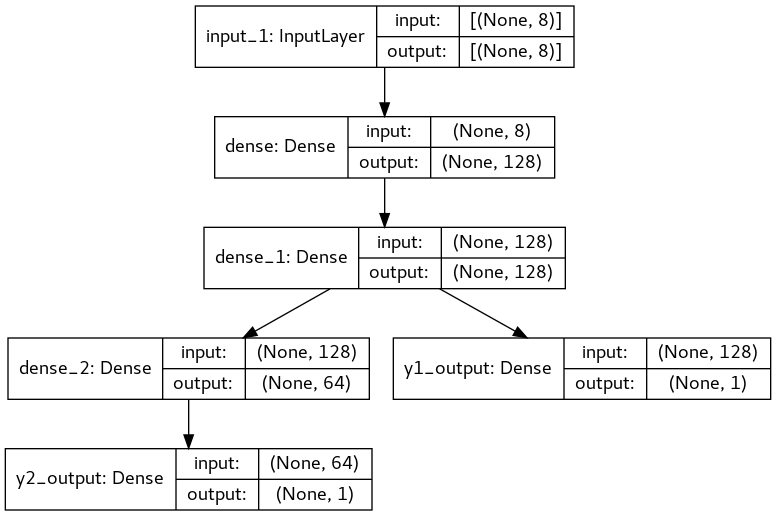

In [6]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Configure parameters

In [7]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'}, # double output
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [8]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 9ms/step - loss: 617.8765 - y1_output_loss: 288.2999 - y2_output_loss: 329.5767 - y1_output_root_mean_squared_error: 16.2972 - y2_output_root_mean_squared_error: 17.3888 - val_loss: 41.9964 - val_y1_output_loss: 14.4671 - val_y2_output_loss: 27.5294 - val_y1_output_root_mean_squared_error: 3.8036 - val_y2_output_root_mean_squared_error: 5.2468
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 40.3434 - y1_output_loss: 15.4062 - y2_output_loss: 24.9372 - y1_output_root_mean_squared_error: 3.9183 - y2_output_root_mean_squared_error: 4.9524 - val_loss: 19.5040 - val_y1_output_loss: 9.2833 - val_y2_output_loss: 10.2206 - val_y1_output_root_mean_squared_error: 3.0469 - val_y2_output_root_mean_squared_error: 3.1970
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 28.3223 - y1_output_loss: 11.2073 - y2_output_loss: 17.1150 - y1_output_root_mean_squared_error: 3.3455 - y2_output_root_mean_squ

## Evaluate the Model and Plot Metrics

In [9]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 816us/step - loss: 0.7319 - y1_output_loss: 0.2318 - y2_output_loss: 0.5001 - y1_output_root_mean_squared_error: 0.4815 - y2_output_root_mean_squared_error: 0.7072
Loss = 0.7319018244743347, Y1_loss = 0.23181574046611786, Y1_mse = 0.4814724624156952, Y2_loss = 0.5000860691070557, Y2_mse = 0.7071676254272461


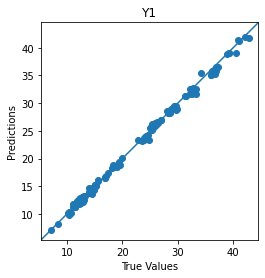

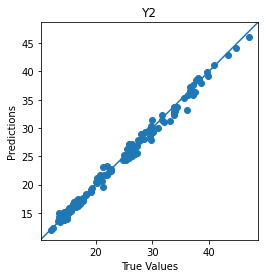

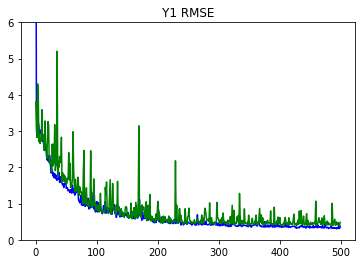

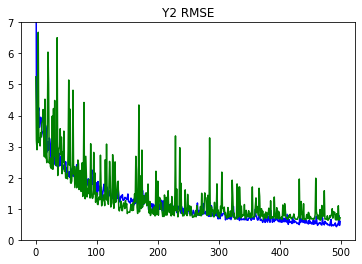

In [10]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)